In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [5]:
#load data
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets('../data/MNIST_data/')

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
class TF_PCA(object):
    def __init__(self, data, dtype=tf.float32):
        self._data=data
        self._dtype=dtype
        self._graph=None
        self._X=None
        self._u=None
        self._singular_values=None
        self._sigma=None
        
    # 
    def fit(self):
        self._graph=tf.Graph()
        with self._graph.as_default():
            self._X=tf.placeholder(self._dtype, shape=self._data.shape)
            # perform svd
            singular_values,u,_=tf.svd(self._X)
            # create sigma matrix
            sigma=tf.diag(singular_values)
            with tf.Session(graph=self._graph) as sess:
                self._u,self._singular_values,self._sigma=sess.run([u,singular_values,sigma],
                                                                  feed_dict={self._X:self._data})
    
    #
    def reduce(self, n_dimensions=None,keep_info=None):
        if keep_info:
            # normalize singular values
            normalized_singular_values=self._singular_values/sum(self._singular_values)
            # information per dimension
            info = np.cumsum(normalized_singular_values)
            # get the first index which is above the given information threshold
            it=iter(idx for idx,value in enumerate(info) if value>=keep_info)
            n_dimensions=next(it)+1
        with self._graph.as_default():
            # cut out the relevant part from sigma matrix
            sigma=tf.slice(self._sigma,begin=[0,0],size=[self._data.shape[1],n_dimensions])
             #pca
            pca=tf.matmul(self._u,sigma)
            with tf.Session(graph=self._graph) as sess:
                return sess.run(pca, feed_dict={self._X:self._data})


In [28]:
data=mnist.train.images
tf_pca=TF_PCA(data)
tf_pca.fit()
pca=tf_pca.reduce(n_dimensions=3,keep_info=None)
print('original data shape',data.shape)
print('reduced data shape',pca.shape)

original data shape (55000, 784)
reduced data shape (55000, 3)


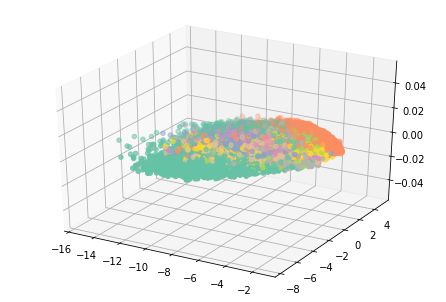

In [29]:
# 绘制三维空间55000个数据点
Set=sns.color_palette('Set2',10)
color_mapping={key:value for (key,value) in enumerate(Set)}
colors=list(map(lambda x:color_mapping[x],mnist.train.labels))
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(pca[:,0],pca[:,1],c=colors)

In [37]:
# tensorboard
import os
from tensorflow.contrib.tensorboard.plugins import projector
images = tf.Variable(mnist.test.images,name='images')
metadata='/Users/hupidong/Work/Learning/learn-tensorflow/data/embedding/metadata.tsv'
with open(metadata,'w') as metadata_file:
    for row in mnist.test.labels:
        metadata_file.write('%d\n' % row)
        
LOG_DIR='/Users/hupidong/Work/Learning/learn-tensorflow/data/embedding/'
with tf.Session() as sess:
    saver=tf.train.Saver([images])
    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR,'images.ckpt'))
    config=projector.ProjectorConfig()
    embedding=config.embeddings.add()
    embedding.tensor_name=images.name
    embedding.metadata_path=metadata
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR),config)
    
# tensorboard --logdir=/Users/hupidong/Work/Learning/learn-tensorflow/data/embedding/